In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


In [4]:
!pip install wget
import wget 
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip', 'data.txt.zip')

100% [......................................................................] 211011981 / 211011981

'data.txt.zip'

In [6]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Предсказание года выхода песни по 90 признакам: 12 из них = среднее значение тембра и 78 = ковариация тембра.

Первое значение - год (целевая переменная), с 1922 по 2011 год.

Песни в основном являются западными, коммерческими треками с 1922 по 2011 год, с пиком в 2000-х годах.

In [88]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [9]:
best_constant = y_train.mean()
print("Test RMSE при наилучшем константном прогнозе. = %.4f" % mean_squared_error(y_test, best_constant * np.ones(y_test.shape),
                                                                 squared=False))
print("Train RMSE при наилучшем константном прогнозе. = %.4f" % mean_squared_error(y_train, best_constant * np.ones(y_train.shape),
                                                                  squared=False))

Test RMSE при наилучшем константном прогнозе. = 10.8525
Train RMSE при наилучшем константном прогнозе. = 10.9398


In [10]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 9.5102
Train RMSE = 9.5528


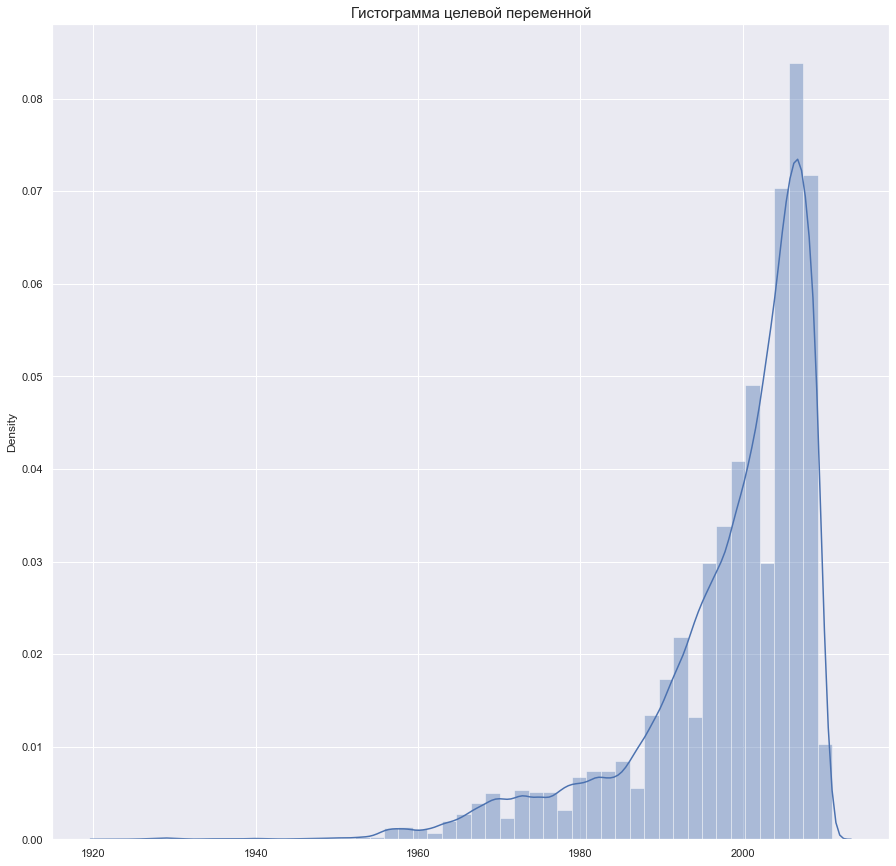

In [338]:
sns.distplot(y).set_title('Гистограмма целевой переменной', fontsize=15)
plt.rcParams['figure.figsize'] = 15, 15
plt.show()

In [311]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [199]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__() 
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

Задаем гиперпараметры:

In [314]:
SEED = 3407
LR = 0.03
NUM_EPOCHS = 6
BATCH_SIZE = 128
EVAL_BATCH_SIZE = 300

Применим операцию нормализации к данным. При подсчете итогового RMSE применим функцию, обратную к нормализации.

In [202]:
norm1 = StandardScaler()
norm2 = StandardScaler()

In [203]:
norm1.fit(y_train.reshape(-1, 1))
norm2.fit(X_train)

y_test_norm = norm1.transform(y_test.reshape(-1, 1))
y_train_norm = norm1.transform(y_train.reshape(-1, 1))

X_test_norm = norm2.transform(X_test)
X_train_norm = norm2.transform(X_train)

In [204]:
train_dl = DataLoader(
    MyDataset(X_train_norm, y_train_norm.reshape(-1)),
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_dl = DataLoader(
    MyDataset(X_test_norm, y_test_norm.reshape(-1)),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
)


dls = {'train': train_dl, 'test': test_dl}

**Архитектура сетки:**

In [205]:
class Model(nn.Module):
    def __init__(self, in_features = 90, out_features = 1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.sequential = nn.Sequential( 
            nn.Linear(in_features, 176), 
            nn.BatchNorm1d(num_features=176),
            nn.ReLU6(), 
            nn.Linear(176, 130), 
            nn.BatchNorm1d(num_features=130),
            nn.ReLU(), 
            nn.Linear(130, 50), 
            nn.BatchNorm1d(num_features=50),
            nn.Sigmoid(),
            nn.Linear(50, self.out_features),
   )
    def forward(self, x): 
        x = self.sequential(x)
        return x

Зададим optimizer и функцию для обучения:

In [206]:
set_random_seed(SEED) 
model = Model()
loss_fn = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Цикл обучения:

In [207]:
metrics_dict = {
    "Эпохи": [],
    "Train RMSE": [],
    "Test RMSE": [],
}
for epoch in tqdm(range(NUM_EPOCHS)):
    metrics_dict["Эпохи"].append(epoch)
    for stage in ['train', 'test']:
        with torch.set_grad_enabled(stage == 'train'):
            if stage == 'train':
                model.train()
            else:
                model.eval() 
            loss_at_stage = 0 
            for batch in dls[stage]:
                x_batch, y_batch = batch
                y_pred = model(x_batch.float()).view(-1) 
                loss = loss_fn(y_pred.float(), y_batch.float()) * 1.1
                if stage == "train":
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                with torch.no_grad():
                    loss_at_stage += (np.square((norm1.inverse_transform(y_pred) - norm1.inverse_transform(y_batch))).sum()).item()
            rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
            metrics_dict[f"{stage.title()} RMSE"].append((rmse_at_stage))
            
    clear_output(wait=True)
    display(pd.DataFrame(metrics_dict))

,Эпохи,Train RMSE,Test RMSE
0,0,8.984928,8.880848
1,1,8.766430,8.795795
2,2,8.682840,8.807227
3,3,8.625357,8.759650
4,4,8.571974,8.795017
5,5,8.535693,8.750503


In [209]:
metrics_dict1 = pd.DataFrame(data=metrics_dict)

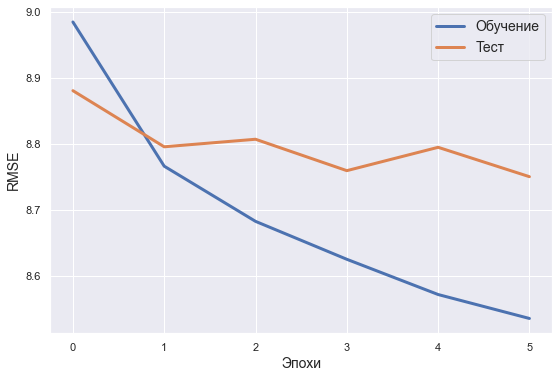

In [337]:
plt.figure(figsize=(9, 6))
plt.plot(metrics_dict1['Train RMSE'], linewidth = 3, label='Обучение')
plt.plot(metrics_dict1['Test RMSE'], linewidth = 3, label='Тест')
plt.xlabel('Эпохи', size=14)
plt.ylabel('RMSE', size=14)
plt.legend(fontsize=14)
plt.grid(b=1)
plt.show()

In [333]:
def rmse(preds, y_true):
    return ((preds - y_true) ** 2).mean() ** (1/2)

def test(model, X_test, y_test):
    preds = model(torch.Tensor(X_test).float()).view(-1)
    rmse_val = rmse(norm1.inverse_transform(preds.detach().numpy()), norm1.inverse_transform(y_test.reshape(-1)))
    print(f'Test: RMSE = {rmse_val}')
    return preds

In [334]:
test(model, X_test_norm , y_test_norm)

Test: RMSE = 8.750503196678293


tensor([ 0.1569,  0.2983,  0.2870,  ..., -0.1107,  0.3976,  0.3394],
       grad_fn=<ViewBackward>)

In [336]:
assert test(model, X_test_norm , y_test_norm).shape[0] == y_test.shape[0]

Test: RMSE = 8.750503196678293


# Отчет:

**В первоначальных эксперементах были рассмотрены такие простые случаи:**

In [ ]:
self.hidden_size = int((in_features + out_features))
self.hidden_size1 = int((in_features + out_features)) * 2
self.sequential = nn.Sequential( 
            nn.Linear(in_features, self.hidden_size), 
            nn.ReLU(), 
            nn.Linear(self.hidden_size, self.hidden_size1), 
            nn.BatchNorm1d(num_features=self.hidden_size1),
            nn.ReLU(), 
            nn.Linear(self.hidden_size1, 70),
            nn.BatchNorm1d(num_features=70),
            nn.ReLU(),  
            nn.Linear(70, 70),
            nn.ReLU(), 
            nn.Linear(70, self.out_features),
            
            
        )
SEED = 3407
LR = 0.02
WEIGHT_DECAY = 1e-3 
NUM_EPOCHS = 5
BATCH_SIZE = 128
EVAL_BATCH_SIZE = 300
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

При данной архитекуре ошибка не опускалась ниже 10:

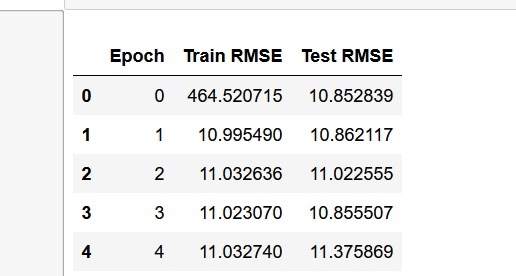

In [318]:
from IPython.display import Image
Image("1.jpg")

**Дальнейшие** эксперименты по изменению размера бача и шага обучения не увенчались успехом и ошибка не падала ниже 10.

В последующих эксперемнтах были добавлены в слои nn.BatchNorm1d в силу больших значениях внутри сетки.

Так же введена новая функция активации Tanh, чтобы подобрать подходящую функцию нелинейности:

In [ ]:
 self.sequential = nn.Sequential( 
            nn.Linear(in_features, self.hidden_size), 
            nn.ReLU(), 
            nn.Linear(self.hidden_size, self.hidden_size1), 
            nn.BatchNorm1d(num_features=self.hidden_size1),
            nn.Tanh(),
            nn.Linear(self.hidden_size1, 70),
            nn.BatchNorm1d(num_features=70),
            nn.ReLU(),  
            nn.Linear(70, 70),
            nn.BatchNorm1d(num_features=70),
            nn.ReLU(), 
            nn.Linear(70, self.out_features),
            
            
        )
SEED = 3407
LR = 0.02
WEIGHT_DECAY = 1e-3 
NUM_EPOCHS = 5
BATCH_SIZE = 128
EVAL_BATCH_SIZE = 300
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

Качество улучшилось, но ошибка не падала меньше 9.

**Также были** протестированы варианты с Dropout, но оказалось, что при небольшом количестве эпох, модель не переобучалась и получалась большая ошибка и нужда в них отпала.

In [ ]:
self.sequential = nn.Sequential( 
            nn.Linear(in_features, 9), 
            nn.BatchNorm1d(num_features=9),
            nn.ReLU(), 
            nn.Dropout(0.2),
            nn.Linear(9, 12), 
            nn.BatchNorm1d(num_features=12),
            nn.ReLU(), 
            nn.Dropout(0.05),
            nn.Linear(12, 95), 
            nn.BatchNorm1d(num_features=95),
            nn.ReLU(), 
            nn.Dropout(0.2),
            nn.Linear(95, self.out_features),
            
            
        )
self.sequential = nn.Sequential( 
            nn.Linear(in_features, 9), 
            nn.BatchNorm1d(num_features=9),
            nn.ReLU(), 
            nn.Dropout(0.2),
            nn.Linear(9, 12), 
            nn.BatchNorm1d(num_features=12),
            nn.ReLU(), 
            nn.Dropout(0.05),
            nn.Linear(12, 95), 
            nn.BatchNorm1d(num_features=95),
            nn.ReLU(), 
            nn.Linear(95, 100), 
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(), 
            nn.Dropout(0.2),
            nn.Linear(100, self.out_features),    
        )
SEED = 3407
LR = 0.02
WEIGHT_DECAY = 1e-3 
NUM_EPOCHS = 5
BATCH_SIZE = 128
EVAL_BATCH_SIZE = 300
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

**Самым оптимальным** оказался случай перемешивания слоев активации.
Так же без использования scheduler на нашей модели, качество было лучше и его пришлось убрать.

Также было выяснено, что большое количество слоев не решают много роли, достаточно 3 линейных слоев:

После подбора слоев, были испробованы различные значения шага([0.01, ..., 0.07]), самым оптимальным оказался 0.03.

In [ ]:
self.sequential = nn.Sequential( 
            nn.Linear(in_features, 176), 
            nn.BatchNorm1d(num_features=176),
            nn.ReLU6(), 
            nn.Linear(176, 130), 
            nn.BatchNorm1d(num_features=130),
            nn.ReLU(), 
            nn.Linear(130, 50), 
            nn.BatchNorm1d(num_features=50),
            nn.Sigmoid(),
            nn.Linear(50, self.out_features),
   )
SEED = 3407
LR = 0.03
NUM_EPOCHS = 6
BATCH_SIZE = 128
EVAL_BATCH_SIZE = 300
set_random_seed(SEED) 
model = Model()
loss_fn = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Модель тестировалась на разных методах градиентного спуска, таких, как: SGD, Adagrad, Adam.

Неудивительно, но самым лучшим оказался один из самых эффективных методов: Adam

Функция nn.ReLU6() добавляла еще больше нелинейности в нашу модель, и делала ее лучше

При подборе различных слоев автивации и шагов обучения и при разных эпохах ошибка не падала ниже значения 8.9:

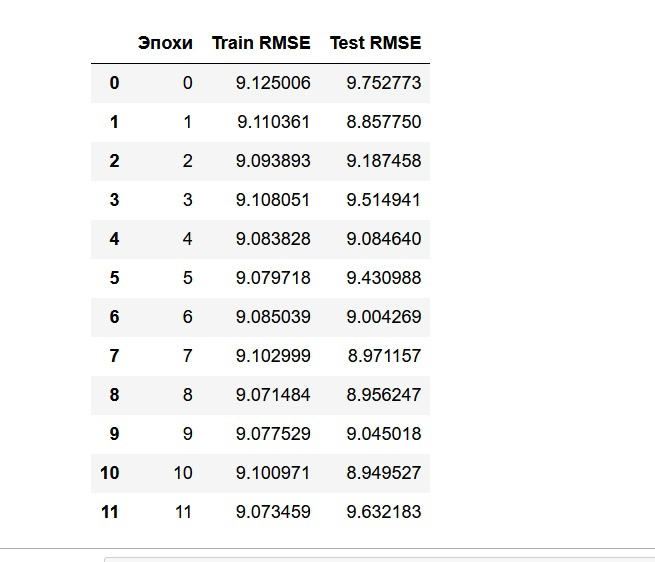

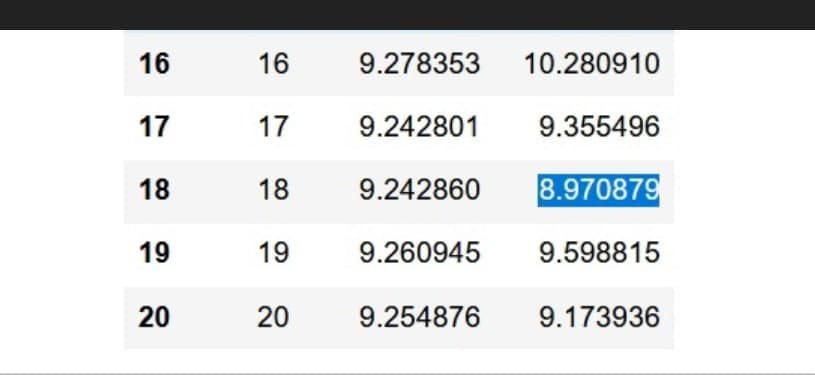

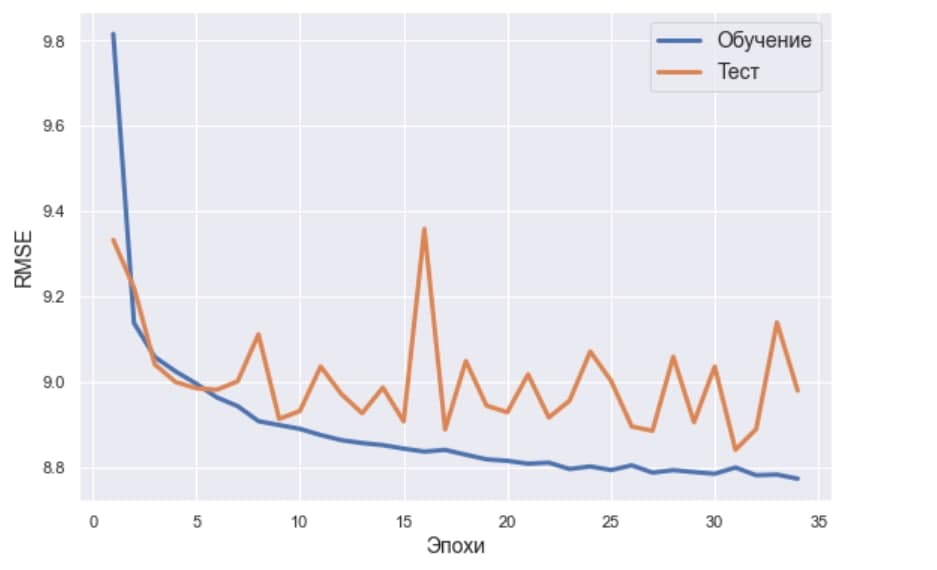

In [326]:
from IPython.display import Image
display(Image("2.jpg"))
display(Image("4.jpg"))
display(Image("5.jpg"))

Для улучшения полученной модели было принято решение применить нормировку  данных и при подсчета RMSE, возвращать вектор целевой переменной и предсказанный вектор к нужному масштабу для вывода корректной ошибки.

Так же было принято умножать функцию потерь на 1,1.

**После примененных модификаций получили отличную ошибку на тесте**
